In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch, torch, tqdm
import warnings
import sys, json,pickle 
import h5py
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.manifold import TSNE
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy import interp

import numpy as np
from mindspore import Tensor
from mindspore.nn.metrics import HausdorffDistance
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

sys.path.append("/home/zhang_istbi/data_disk/zhaobt/projects/tumor_cls/")

from nets import Losses
from utils import data_generator
from nets import unet, resnet
from utils import file_io
from utils import logger
from utils import model_io

/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/home/zhang_istbi/miniconda3/envs/pt10/lib/python3.8/site-packages/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


# utils

In [19]:
def acc(pred, y_true):
    res = 0
    i = 0
    for p, t in zip(list(pred), list(y_true)):
        i += 1
        if p == t:
            res += 1
    return res/i

def cal_cls_res(label, pred, prob=None):
    
#     print(np.unique(label))
    
    p = precision_score(label, pred, average='binary')
    r = recall_score(label, pred, average='binary')
    f1score = f1_score(label, pred, average='binary')
    acc = np.sum(np.array(label)==np.array(pred))/len(pred)
    print("acc:", acc)
    print("precision_score:", p)
    print("recall_score:", r)
    print("f1_score:", f1score)
    if prob is not None:
        fpr,tpr,threshold = roc_curve(label,prob) ###计算真正率和假正率
        roc_auc = auc(fpr,tpr)
        print("roc_auc:", roc_auc)
    return acc, p, r, f1score, roc_auc

In [20]:
def dice_coeff(pred, target):
    smooth = 1.
#     num = pred.size(0)
#     m1 = pred.view(num, -1)  # Flatten
#     m2 = target.view(num, -1) # Flatten
    m1 = np.reshape(pred, (-1))
    m2 = np.reshape(target, (-1))
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


In [21]:
def hausdorff_95(x, y, idx):
    '''
    :params input_tensor:   the result of segmentation
    :params target:         ground true mask
    :params num_class:      label number
    '''
    metric = HausdorffDistance(percentile=95.0)
    metric.clear()
    metric.update(x, y, idx)
    distance = metric.eval()
    return distance
# x = Tensor(np.array([[3, 0, 1], [1, 3, 0], [1, 0, 2]]))
# y = Tensor(np.array([[0, 2, 1], [1, 2, 1], [0, 0, 1]]))
# hausdorff_95(x, y, 1)

In [22]:
def merge_slice(index, pred, labels):
    data = {}
    label = []
    temp = -1
    temp_l = -1
    for idx, i in enumerate(index):
        if temp != i:
            temp = i
            label.append(labels[idx])
        if temp not in data:
            data[temp] = [pred[idx]]
        else:
            data[temp].append(pred[idx])
    return data, label

In [23]:
def expand_slice(index, pred, labels):
    data = {}
    label = []
    temp = -1
    temp_l = -1
    for idx, i in enumerate(index):
        if temp != i:
            temp = i
            label.append(labels[idx])
        if temp not in data:
            data[temp] = [pred[idx]]
        else:
            data[temp].append(pred[idx])
    return data, label

# infer

In [24]:
labeled_f_val = h5py.File(r"../../../dataset/tumor_cls/h5_dataset_expert/2d_deskull_test.h5", 'r')

# 标签是四个类别，这里只做二分类
try:
    temp = np.zeros_like(labeled_f_val['label'][:])
#     temp[labeled_f_val['label'][:] == 1] = 1
    val_labels = temp.copy()
    print("==>setting target label {}".format(cfg.net.cls_label))
except:
    val_labels = labeled_f_val['label'][:]
#     val_labels[val_labels != 1] = 0
indexs = labeled_f_val['index_info'][:]
val_cls_dataset = data_generator.cls_val_2D_age(labeled_f_val['img'],
                                                labeled_f_val['mask'], val_labels,
                                                labeled_f_val['age_info'], labeled_f_val['sex_info'], )
val_dataLoader = DataLoader(val_cls_dataset, batch_size=1, shuffle=False)
# labeled_f_val.close()

In [25]:
# labeled_f_val.close()

In [26]:
def evaluate_dice_age(model, indexs, val_dataLoader):
    model.eval()
    model.cuda()
    pred = []
    pres_prob = []
    dices = []
    hausdorffs = []
    
    first_index = 0
    temp_tumor = []
    temp_seg = []
    for idx, data in tqdm.tqdm(enumerate(val_dataLoader)):
        img, tumor, label, age, sex = data
        img = img.cuda()
        tumor = tumor.cuda()
        age, sex = age.cuda(), sex.cuda()
        seg, pred_label = model(img, age, sex)
#         print(seg.size(), tumor.size())
        seg = F.softmax(seg, dim=1)
        seg = torch.max(seg, dim=1)[1]
#         print(seg.size(), tumor.size())
        if indexs[idx]==first_index and idx != len(val_dataLoader):
            temp_tumor.append(tumor.cpu().detach().numpy())
            temp_seg.append(seg.cpu().detach().numpy())
        else:
            dice = dice_coeff(np.stack(temp_tumor), np.stack(temp_seg))
            hausdorff = hausdorff_95(np.stack(temp_tumor), np.stack(temp_seg), idx=1)
            first_index = indexs[idx]
            temp_tumor = [tumor.cpu().detach().numpy()]
            temp_seg = [seg.cpu().detach().numpy()]
            print(dice, hausdorff)
            dices.append(dice)
            hausdorffs.append(hausdorff)
#             break
#         dice = dice_coeff(seg, tumor)
#         hausdorff = hausdorff_95(seg.cpu().detach().numpy(), tumor.cpu().detach().numpy(), idx=1)
#         print(hausdorff)
        pred_label_prob = F.softmax(pred_label, dim=1)
        pred.append(torch.max(pred_label, dim=1)[1].item())
        pres_prob.append(pred_label_prob[0, 1].item())
        
        
    print(np.mean(dices))
    print(np.mean(hausdorffs))
    return pred, pres_prob

In [12]:
# pathes = ["../cpts/cls_expert/2d_xuemu_deskull_prior/model/400_model.pth"]
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
pathes = ["../cpts/cls_expert/2d_xuemu_deskull_prior/model/400_model.pth",
          "../cpts/cls_expert/2d_PA_deskull_prior/model/400_model.pth",
          "../cpts/cls_expert/2d_haimian_deskull_prior/model/400_model.pth",
          "../cpts/cls_expert/2d_giloma_deskull_prior/model/400_model.pth",
         ]

test_pred_prob_tumors = []
test_pred_tumors = []

train_pred_prob_tumors = []
train_pred_tumors = []
for path in pathes:
    print("running {}".format(path))
    checkpoint = torch.load(path)
    model = unet.UnetPP_Cls_age(encoder_name='resnet18', in_channels=1, classes=2, aux_params=dict(
                            pooling='avg',  # one of 'avg', 'max'
                            dropout=0,  # dropout ratio, default is None
                            activation=None,  # activation function, default is None
                            classes=2,  # define number of output labels
                            ))
#     model = unet.UnetPlusPlus_Cls('resnet18', 2, 2 )
#     print(model)
    model.load_state_dict(checkpoint['state_dict'])
#     pred, pres_prob = evaluate(model, train_dataLoader)
#     train_pred_prob_tumors.append(pres_prob)
#     train_pred_tumors.append(pred)
    
#     pred, pres_prob = evaluate_dice_age(model, indexs, val_dataLoader)
    
#     val_cls_dataset = data_generator.cls_generator_2D(labeled_f_val['img'],
#                                                       labeled_f_val['mask'], val_labels,
#                                                       rotate_degree=0,
#                                                       noise_sigma=(0, 1e-9), )
#     val_dataLoader = DataLoader(val_cls_dataset, batch_size=1, shuffle=False)
    
#     pred, pres_prob = evaluate_dice_age(model, indexs, val_dataLoader)
    pred, pres_prob = evaluate_dice_age(model, indexs, val_dataLoader)
    test_pred_prob_tumors.append(pres_prob)
    test_pred_tumors.append(pred)

running ../cpts/cls_expert/2d_xuemu_deskull_prior/model/400_model.pth


54it [00:01, 77.87it/s]

0.7294836586753755 30.218371317904104
0.24063321312878186 23.323807579381203


107it [00:01, 108.13it/s]

0.6634661354581673 11.313708498984761
0.7750812988399748 27.579882617836986


161it [00:01, 118.99it/s]

0.47107396149949343 13.802066772709269
0.6502890173410405 13.579323919634758


188it [00:02, 122.91it/s]

0.16852191875143446 30.24896692450835


215it [00:02, 123.23it/s]

0.6360735891273722 12.083045973594572


256it [00:02, 122.72it/s]

0.5309838591937708 26.565934458840214


297it [00:03, 121.72it/s]

0.7764987886634279 12.884098726725126


322it [00:03, 113.07it/s]

0.3012893574583274 33.52014240118109


334it [00:03, 103.01it/s]

0.7613497999652113 34.14380546431311


369it [00:03, 98.19it/s] 

0.7272127513590542 32.03045407764744


416it [00:04, 98.35it/s] 

0.8647404332369113 6.324555320336759


441it [00:04, 105.06it/s]

0.4501009973488196 16.30950643030009


481it [00:04, 111.88it/s]

0.3709215230097032 16.673332000533065


507it [00:05, 113.03it/s]

0.6829709759161857 30.430248109405877


532it [00:05, 112.37it/s]

0.2869031639501438 35.185224171518364
0.2980713874496258 19.1049731745428


572it [00:05, 118.33it/s]

0.8089971674994431 10.198039027185569
0.43833024716206426 22.627416997969522


609it [00:05, 118.80it/s]

0.41566967298607277 34.26368339802363


650it [00:06, 118.97it/s]

0.7545909570283074 32.0624390837628


675it [00:06, 113.92it/s]

0.26335727251203533 25.612496949731394
0.5114521657837332 20.615528128088304


757it [00:07, 101.90it/s]

0.771466171435003 12.0


811it [00:07, 111.94it/s]

0.8048672062008435 11.74734012447073


865it [00:08, 105.17it/s]

0.6785617476683365 13.892443989449804


919it [00:08, 112.86it/s]

0.6957711825311395 35.38361202590826


959it [00:09, 111.11it/s]

0.7203353743594262 17.291616465790582


998it [00:09, 115.90it/s]

0.6850241120384031 33.2264954516723


1039it [00:09, 119.47it/s]

0.8059818015398698 9.16515138991168


1080it [00:10, 116.22it/s]

0.8724376536324948 10.473753889864218
0.5582712749029343 23.75393600955967


1119it [00:10, 115.14it/s]

0.7464446460048261 15.0


1146it [00:10, 117.97it/s]

0.1334367552497864 38.0


1172it [00:10, 119.51it/s]

0.5899318156823931 29.46523296944344


1227it [00:11, 113.04it/s]

0.7772268149936584 15.7797338380595
0.6369043080442242 23.790754506740637


1294it [00:11, 118.48it/s]

0.6956772866945452 19.924843042696203


1321it [00:12, 116.65it/s]

0.7291915158429705 22.825424421026653


1347it [00:12, 116.79it/s]

0.08250632985070283 44.87090407808759


1373it [00:12, 119.36it/s]

0.5251927053957511 30.1279824137864


1400it [00:12, 119.66it/s]

0.5546894272041047 43.91810536963646


1438it [00:13, 114.14it/s]

0.8679127553072006 24.186773244895647
0.5416176662746636 40.792156108742276


1492it [00:13, 117.75it/s]

0.5665840842025532 14.212670403551895


1533it [00:14, 115.09it/s]

0.8233945553918706 10.770329614269007


1559it [00:14, 114.74it/s]

0.7539095118803614 21.307275752662516


1600it [00:14, 117.76it/s]

0.742318470492646 9.0


1641it [00:14, 121.82it/s]

0.6319189882697948 13.416407864998739


1682it [00:15, 113.38it/s]

0.7508616489524875 26.43860813280457


1708it [00:15, 112.31it/s]

0.3349888080581981 36.124783736376884


1761it [00:16, 107.13it/s]

0.8295337192927554 7.0
0.5627252101961832 31.064449134018133


1801it [00:16, 119.38it/s]

0.7869136053729521 3.0


1842it [00:16, 119.20it/s]

0.6988567339535039 17.72004514666935
0.6212624584717608 32.44686736065887


1882it [00:17, 111.39it/s]

0.5071609403254973 30.23243291566195
0.2741126184724029 39.67366884975475


1937it [00:17, 119.15it/s]

0.7347611644239532 14.352700094407323


1964it [00:17, 117.74it/s]

0.7761540669606743 28.0178514522438


2016it [00:18, 104.91it/s]

0.6895539988488482 9.876708225944625


2042it [00:18, 113.41it/s]

0.7821669884169884 14.317821063276353
0.6061394380853278 39.071724638544204


2104it [00:19, 103.04it/s]

0.8126338596403845 45.139228722164724


2142it [00:19, 109.28it/s]

0.8179803820898749 22.13255373612624
0.3795320989023173 39.81205847478876


2182it [00:19, 119.81it/s]

0.46350189198486413 20.12461179749811


2223it [00:20, 119.81it/s]

0.42483207534104284 34.6193384360216


2264it [00:20, 120.98it/s]

0.8345821885493853 6.4031242374328485


2292it [00:20, 118.00it/s]

0.825404218510879 16.881943016134134
0.6771021021021021 18.35755975068582


2332it [00:21, 125.46it/s]

0.23088649155722327 36.0


2359it [00:21, 122.01it/s]

0.584695333197473 19.672315572906
0.45393096570447117 28.460498941515414


2411it [00:21, 115.08it/s]

0.5799975922470355 37.134889255254286
0.3604169860493638 33.67491648096547


2466it [00:22, 120.62it/s]

0.870161919284808 16.101236578722585


2507it [00:22, 119.30it/s]

0.8574190634790708 33.30915705430439


2534it [00:22, 118.23it/s]

0.8647575186226935 35.178117480828156


2575it [00:23, 119.56it/s]

0.699849811556009 32.64965543462902


2602it [00:23, 118.66it/s]

0.8292305776375599 10.0
0.7224851322282677 13.416407864998739


2641it [00:23, 118.02it/s]

0.67462482946794 4.0
0.43056936847339633 21.97726097583591


2709it [00:24, 111.75it/s]

0.8844712984469157 9.121377141297716
0.3165609730741241 39.35733730830886


2750it [00:24, 119.68it/s]

0.618604099308872 15.7797338380595


2791it [00:24, 110.80it/s]

0.627366679105083 21.118712081942874
0.41058798691016574 27.85677655436824


2844it [00:25, 113.33it/s]

0.6844103481275788 31.176914536239792
0.7738231227078699 21.784099781500572


2897it [00:25, 117.11it/s]

0.47526696714106714 29.986659251017368


2938it [00:26, 117.08it/s]

0.7780986523268937 10.488088481701515


2963it [00:26, 113.04it/s]

0.644589552238806 42.30839160261236


3002it [00:26, 116.14it/s]

0.7571406165589112 21.60555285696401


3026it [00:27, 112.30it/s]

0.5894877298833904 24.698178070456937
0.46026036313806096 36.796738985948195


3062it [00:27, 112.19it/s]


0.6155564815137415
23.651364540923986
running ../cpts/cls_expert/2d_PA_deskull_prior/model/400_model.pth


56it [00:00, 120.68it/s]

0.7110685542519151 23.78444674912127
0.2333833683578505 19.72308292331602


109it [00:00, 116.59it/s]

0.6208397449989008 9.1104335791443
0.7845199979671698 25.133638772363447


163it [00:01, 120.82it/s]

0.5440289505428226 10.63014581273465
0.6813608684140853 5.472622536655787


190it [00:01, 124.01it/s]

0.1995068830901993 25.179356624028344


217it [00:01, 122.46it/s]

0.7124453539205655 6.4031242374328485


257it [00:02, 120.03it/s]

0.5738289480793127 22.360679774997898


298it [00:02, 121.44it/s]

0.7852429746933706 9.944836427620727


311it [00:02, 117.83it/s]

0.6135719491456798 24.95194226134387
0.6656780938976575 36.178722526991045


378it [00:03, 120.79it/s]

0.8149901733071289 30.083217912982647


405it [00:03, 114.66it/s]

0.8606808737583609 6.324555320336759


433it [00:03, 119.14it/s]

0.4348144142997996 16.229577983361928


474it [00:03, 116.53it/s]

0.3638988155615549 16.401219466856727


501it [00:04, 116.42it/s]

0.698151463514592 27.748873851023216


542it [00:04, 120.23it/s]

0.5181686920948141 19.320969422823698
0.32560046865846515 26.248809496813376


570it [00:04, 119.86it/s]

0.8362447561615102 8.06225774829855


596it [00:05, 116.82it/s]

0.5267602603410252 26.851443164195103
0.549660652209899 21.118712081942874


651it [00:05, 123.57it/s]

0.8407935455349248 4.123105625617661
0.22679188255613125 24.18573918001032


690it [00:05, 123.57it/s]

0.5995128112594731 8.94427190999916


760it [00:06, 108.21it/s]

0.8250757132989746 12.083045973594572


802it [00:06, 113.93it/s]

0.8159611922155071 14.422205101855956


871it [00:07, 104.87it/s]

0.6783077060822114 19.0


912it [00:07, 112.55it/s]

0.7216943521594684 28.653097563788805


967it [00:08, 115.72it/s]

0.721783196239718 18.110770276274835


994it [00:08, 115.67it/s]

0.7314334660616724 34.35912916216642


1035it [00:08, 121.31it/s]

0.8408956982911019 3.1622776601683795


1076it [00:09, 117.06it/s]

0.8734389905472205 4.358898943540674


1103it [00:09, 121.92it/s]

0.6900383754397186 16.1245154965971
0.7660587532504041 7.0710678118654755


1143it [00:09, 117.26it/s]

0.2489022124641108 34.0
0.7648317377429649 23.010859296370036


1225it [00:10, 116.91it/s]

0.7694599262404501 12.658977365617519
0.6897722567287785 12.008144080441413


1291it [00:11, 107.39it/s]

0.6946045171484339 13.92838827718412


1316it [00:11, 110.90it/s]

0.7579066265060241 13.946314160476529
0.3058139534883721 34.597687784012386


1367it [00:11, 109.04it/s]

0.5767606985223566 26.180009546412247


1393it [00:11, 117.18it/s]

0.7048332752410829 53.74011537017761


1432it [00:12, 114.52it/s]

0.8651756052879818 13.762255751756587
0.6782997022825008 10.704749018197552


1488it [00:12, 123.05it/s]

0.6075827948303716 9.486832980505138


1529it [00:13, 119.14it/s]

0.7956650511577814 11.357816691600547


1571it [00:13, 125.54it/s]

0.7845173798642847 6.0


1598it [00:13, 122.42it/s]

0.7390625 9.219544457292887


1638it [00:13, 123.92it/s]

0.6674781612487469 7.615773105863909


1677it [00:14, 113.73it/s]

0.8176264758777074 18.23457737459163


1715it [00:14, 113.01it/s]

0.6095607345234545 31.461086433490195


1756it [00:14, 114.08it/s]

0.8383697813121272 15.394804318340652
0.6226529836564044 12.810146885245636


1795it [00:15, 122.53it/s]

0.7685034566897113 13.475892156768705


1838it [00:15, 119.68it/s]

0.7206343878492909 13.601470508735444
0.7587414989352201 33.46116409463196


1891it [00:16, 122.30it/s]

0.5787944237188297 25.178363355367836
0.4263005780346821 35.72463260488768


1932it [00:16, 126.38it/s]

0.7547468846141894 16.0312195418814


1960it [00:16, 122.47it/s]

0.8144246571651804 38.78917323325724


2014it [00:17, 117.41it/s]

0.7750082284730486 25.12965783397037
0.8446369572569525 10.0


2066it [00:17, 116.77it/s]

0.6281995869951496 40.49073826939891


2107it [00:17, 114.53it/s]

0.796844348647405 31.524592136386715


2147it [00:18, 117.64it/s]

0.8268823998022141 33.7157031501893
0.5764607679465776 19.6468827043885


2188it [00:18, 125.78it/s]

0.5239859995882232 20.528008765431036


2215it [00:18, 121.52it/s]

0.544442465265408 30.67409291367151


2254it [00:19, 102.16it/s]

0.7504010104199558 26.88678759026388


2287it [00:19, 89.37it/s] 

0.8352003649096447 8.94427190999916
0.6504583213978803 17.479982764952577


2318it [00:19, 94.46it/s]

0.2945840813883902 25.337718918639855


2351it [00:20, 94.61it/s]

0.568806241623588 11.045361017187261


2373it [00:20, 95.37it/s]

0.6545075125208681 21.18962010041709


2408it [00:20, 102.20it/s]

0.7088816392360984 7.0
0.31716231932214656 29.55587808142867


2459it [00:21, 108.81it/s]

0.9084709604736451 12.68857754044952


2499it [00:21, 113.05it/s]

0.8502884778550823 4.7529848775463455


2537it [00:22, 112.11it/s]

0.8464991555305342 36.124783736376884


2564it [00:22, 112.22it/s]

0.686111772509269 25.6729422911212


2603it [00:22, 113.69it/s]

0.8673911644173622 7.0710678118654755


2627it [00:22, 111.99it/s]

0.7590864969801553 10.691065956366932
0.518320610687023 5.0


2652it [00:23, 115.57it/s]

0.6436644307635763 26.26017640852611


2703it [00:23, 103.40it/s]

0.8882460692203976 8.94427190999916
0.395895436826416 37.078289265869245


2744it [00:23, 113.66it/s]

0.6908313444709626 9.219544457292887


2796it [00:24, 109.01it/s]

0.6173879431139171 21.283796653792763
0.485731194108364 23.78444674912127


2847it [00:24, 106.11it/s]

0.8015240414775453 19.74081723768685
0.7548589713202181 40.80012213009391


2900it [00:25, 115.36it/s]

0.6419806188801458 23.08679276123039


2941it [00:25, 114.83it/s]

0.8195688772206591 9.899494936611665


2967it [00:25, 112.37it/s]

0.7325450565636316 42.34678233188388


2992it [00:26, 110.01it/s]

0.8003524719413784 29.8496231131986


3017it [00:26, 113.94it/s]

0.7157475162115533 22.9128784747792
0.3228423772609819 24.372115213907882


3062it [00:26, 114.80it/s]


0.6645561761006122
19.787582442293093
running ../cpts/cls_expert/2d_haimian_deskull_prior/model/400_model.pth


55it [00:00, 115.13it/s]

0.541792457885993 28.5657137141714


81it [00:00, 114.11it/s]

0.13223797114345642 41.048751503547585


106it [00:00, 114.45it/s]

0.610628759505164 15.565971710960412


132it [00:01, 115.09it/s]

0.4370411109583391 55.072679252057455


156it [00:01, 108.50it/s]

0.27795705233513257 20.248456731316587
0.3842843362766194 25.51763999813533


195it [00:01, 117.50it/s]

0.14513173966149015 33.74536944274581


220it [00:01, 113.53it/s]

0.29315408085430966 35.64266928997951


261it [00:02, 109.50it/s]

0.23934439162935642 43.73785545725808


286it [00:02, 107.02it/s]

0.649637127578304 13.601470508735444


312it [00:02, 108.67it/s]

0.20243118564026324 32.84813188453698


337it [00:03, 110.05it/s]

0.45906154369262153 36.193922141707716


377it [00:03, 114.25it/s]

0.5465214904234965 27.93474408563708


418it [00:03, 113.68it/s]

0.7617853225883363 16.911534525287763


444it [00:04, 115.16it/s]

0.3980982652731387 20.024984394500787


469it [00:04, 109.03it/s]

0.3825353104679973 19.4164878389476


509it [00:04, 112.23it/s]

0.531616429281219 31.591137997862628


533it [00:04, 107.00it/s]

0.20717644277496125 33.015148038438355
0.23363643195310738 55.624590800164064


571it [00:05, 110.64it/s]

0.7144267950037555 17.03817953463268


596it [00:05, 107.22it/s]

0.4249352056013307 23.323807579381203
0.27982442977190874 39.0


648it [00:05, 114.65it/s]

0.6311449543801879 28.231188426986208


671it [00:06, 106.88it/s]

0.17223389609448592 28.30194339616981
0.3270579006716674 21.725512067302045


751it [00:06, 90.48it/s] 

0.7062661199427461 22.090722034374522


809it [00:07, 95.72it/s] 

0.6891560921047557 29.221566926466462


863it [00:08, 95.51it/s] 

0.6099700228314482 18.24828759089466


918it [00:08, 107.02it/s]

0.4520537077804883 39.370039370059054


971it [00:09, 107.26it/s]

0.5974278290304894 21.470910553583888


997it [00:09, 107.75it/s]

0.5013885344581713 50.6453353762167


1037it [00:09, 110.82it/s]

0.7285553990498246 32.02498932852205


1076it [00:10, 105.92it/s]

0.7400696544771331 19.82422760159901


1102it [00:10, 112.87it/s]

0.4779585873343745 28.802770118963124


1128it [00:10, 114.85it/s]

0.7230192559666959 17.46424919657298


1154it [00:10, 114.61it/s]

0.09415262636273539 42.638011210655684


1180it [00:10, 113.77it/s]

0.4667316763425254 38.948684188300895


1221it [00:11, 98.66it/s] 

0.657028759138192 18.867962264113206
0.2782454733747578 32.155870381627054


1285it [00:11, 108.77it/s]

0.5837890452172374 30.029984276211373


1325it [00:12, 114.14it/s]

0.4751416621694549 27.367864366808018


1351it [00:12, 114.01it/s]

0.15023464762745176 53.03772242470448


1376it [00:12, 114.33it/s]

0.2332490974729242 41.98392511105286


1402it [00:12, 112.83it/s]

0.250450337229274 44.609416046390926


1427it [00:13, 109.20it/s]

0.753109365502408 28.071337695236398
0.4750369612191516 32.31949784203223


1493it [00:13, 112.28it/s]

0.45506831393554914 24.677925358506133


1534it [00:14, 109.41it/s]

0.7068397779659422 24.372115213907882


1560it [00:14, 110.03it/s]

0.6978407252100987 21.458095573352715


1600it [00:14, 111.31it/s]

0.646133909287257 15.684387141358123


1641it [00:15, 114.21it/s]

0.3953769239411302 29.614185789921695


1682it [00:15, 108.43it/s]

0.600148267480237 24.228082879171435


1708it [00:15, 108.11it/s]

0.21821481402406478 39.153543900903784


1749it [00:16, 83.56it/s] 

0.7373137242596041 30.528675044947494


1772it [00:16, 91.53it/s]

0.24497282983477228 30.675723300355934
0.5604126091033687 20.024984394500787


1839it [00:17, 93.99it/s] 

0.5403866576250368 24.43358344574123


1861it [00:17, 100.14it/s]

0.4602156805596036 35.6524866632246


1882it [00:17, 96.59it/s] 

0.354429534681888 32.0624390837628
0.07687496742586127 50.21951811795888


1929it [00:18, 101.61it/s]

0.5360532953385833 35.394913873535614


1963it [00:18, 99.01it/s] 

0.49345556235831417 49.658836071740545


2010it [00:18, 94.12it/s] 

0.5715099772063822 31.32091952673165


2033it [00:19, 98.55it/s]

0.6470658898432339 19.313207915827967


2056it [00:19, 101.45it/s]

0.43530428424236384 41.773197148410844


2103it [00:19, 95.44it/s] 

0.622572598484492 46.238512086787566


2138it [00:20, 96.66it/s] 

0.6735075041689828 23.919546486064192
0.2781483245990154 42.720018726587654


2185it [00:20, 104.28it/s]

0.2876203218493329 27.586228448267445


2220it [00:21, 100.72it/s]

0.10813469963614762 43.474130238568314


2255it [00:21, 95.81it/s] 

0.6452482845510678 27.48908737515163


2290it [00:21, 93.89it/s] 

0.6973129198562724 33.83784863137726
0.46127895266868074 30.083217912982647


2322it [00:22, 100.51it/s]

0.11589852257342986 50.00999900019995


2357it [00:22, 102.15it/s]

0.4940403005464481 22.93468988235943


2380it [00:22, 100.97it/s]

0.21044049647116086 41.42281957350814


2413it [00:23, 95.51it/s] 

0.5300294566877591 31.827660925679098
0.20442850460003117 63.324560795950255


2460it [00:23, 97.74it/s] 

0.72703635418144 26.645825188948457


2507it [00:23, 96.47it/s] 

0.720600706713781 37.749787868537844


2530it [00:24, 95.31it/s]

0.8292430052549353 38.8329756778952


2565it [00:24, 96.90it/s] 

0.3478149997315724 42.94938846089759


2600it [00:24, 98.40it/s] 

0.7146442573152051 20.248456731316587


2621it [00:25, 96.07it/s]

0.5937531085248184 17.26267650163207
0.3126959247648903 27.879202637640205


2656it [00:25, 102.41it/s]

0.22962367320681892 24.535688292770594


2701it [00:25, 90.23it/s] 

0.8262474320136495 14.247806848775006
0.23070069369312035 34.17601498127012


2747it [00:26, 99.60it/s] 

0.488868578927634 37.82855832961354


2792it [00:26, 93.23it/s] 

0.4914760235681353 23.173260452512935
0.3151025481665631 25.495097567963924


2849it [00:27, 90.64it/s] 

0.41142415712877706 37.86819245752297
0.632187833511206 31.448370387032774


2895it [00:27, 96.88it/s] 

0.29397687861271676 40.54009938002805


2930it [00:28, 96.83it/s] 

0.693301690318206 16.881943016134134


2965it [00:28, 98.10it/s] 

0.42304233704369804 45.40099092819123


3000it [00:29, 99.52it/s] 

0.6272560853522496 41.44876355212541


3021it [00:29, 95.30it/s]

0.41755896958410926 37.55327374907956
0.31168630361505395 36.87817782917155


3062it [00:29, 103.36it/s]


0.4643560573568038
31.68970662213385
running ../cpts/cls_expert/2d_giloma_deskull_prior/model/400_model.pth


60it [00:00, 106.99it/s]

0.6752113628677714 21.236760581595302


83it [00:00, 106.97it/s]

0.18775648143677884 23.831682651798733


106it [00:00, 106.11it/s]

0.6528700081870281 8.94427190999916


129it [00:01, 105.91it/s]

0.6349710982658959 31.464265445104548


152it [00:01, 103.51it/s]

0.3067295188556567 21.213203435596427
0.5893305917294951 12.409673645990857


186it [00:01, 104.68it/s]

0.14077081000373273 29.068883707497267


221it [00:02, 104.60it/s]

0.4753758584421209 25.768197453450252


256it [00:02, 99.52it/s] 

0.3224207222271114 42.871902220452036


291it [00:02, 99.97it/s] 

0.727169671730129 15.165750888103101


314it [00:03, 101.48it/s]

0.3458031696341225 25.25866188063018


337it [00:03, 103.49it/s]

0.6918465227817746 25.95951029382651


372it [00:03, 102.40it/s]

0.6103227509735331 22.825424421026653


407it [00:03, 100.74it/s]

0.7835914073637124 16.64331697709324


431it [00:04, 102.57it/s]

0.40555480287223955 18.24280350437345


467it [00:04, 96.14it/s] 

0.3899091054845035 17.11724276862369


502it [00:04, 99.81it/s] 

0.652029098042421 27.941008083736314


537it [00:05, 99.41it/s] 

0.2028611111111111 35.827363191460556
0.29657842157842157 23.08679276123039


572it [00:05, 102.17it/s]

0.7897376364058509 11.180339887498949


595it [00:05, 102.54it/s]

0.3982323232323232 24.916858298782053
0.3179805137289637 45.221676218380054


641it [00:06, 101.56it/s]

0.6615085648481359 26.81413642672482


662it [00:06, 91.70it/s] 

0.3841273842534241 24.73863375370596
0.46099493255299406 19.78128959794117


757it [00:07, 91.24it/s] 

0.7596586570486263 21.37755832643195


811it [00:08, 108.38it/s]

0.7605918448553897 13.114877048604


866it [00:08, 101.51it/s]

0.6498228856093389 17.216221163965358


906it [00:08, 106.65it/s]

0.6010790984477993 46.447819137636074


961it [00:09, 110.21it/s]

0.6465843173813963 19.964956140281966


1002it [00:09, 114.70it/s]

0.5948707710178598 44.58923614376382


1027it [00:09, 113.68it/s]

0.7695763636825139 30.541770458917384


1082it [00:10, 113.93it/s]

0.8450888602637008 8.774964387392123


1094it [00:10, 111.02it/s]

0.5100252062328139 30.680605390681066


1121it [00:10, 114.41it/s]

0.730224380442063 21.840329667841555


1147it [00:11, 113.50it/s]

0.12154639805884632 39.57271787481876


1173it [00:11, 114.55it/s]

0.578973923203569 30.0823866551708


1227it [00:11, 107.92it/s]

0.7408185519046234 17.457085840970407
0.4495601014735251 29.483045061351827


1291it [00:12, 110.12it/s]

0.556575488746509 26.14478742451899


1316it [00:12, 107.74it/s]

0.6741060715142788 21.93171219946131


1342it [00:12, 110.65it/s]

0.15125622114289142 45.48626166217664


1367it [00:13, 112.77it/s]

0.47823651784285487 34.19063886712213


1392it [00:13, 112.00it/s]

0.2959935207916783 43.139309220245984


1430it [00:13, 109.05it/s]

0.8665017687375636 8.246211251235321
0.5185139010098492 42.47228612346122


1483it [00:14, 112.78it/s]

0.5172529167030345 17.029386365926403


1537it [00:14, 110.50it/s]

0.8135259356533159 12.177834227137588


1562it [00:14, 110.57it/s]

0.7830511811023622 10.246950765959598


1600it [00:15, 107.27it/s]

0.6686626476710551 15.524174696260024


1638it [00:15, 112.51it/s]

0.5416297096139755 29.274562336608895


1676it [00:15, 108.06it/s]

0.7166582399972578 19.209372712298546


1715it [00:16, 110.00it/s]

0.25318703733009795 41.340053217188775


1754it [00:16, 107.27it/s]

0.8068487672834095 13.892443989449804
0.38615123194562445 25.65151067676132


1805it [00:17, 116.33it/s]

0.6452716801602537 15.748015748023622


1845it [00:17, 112.71it/s]

0.6355811459878674 22.627416997969522
0.4807918207526648 36.40741617923442


1882it [00:17, 106.57it/s]

0.46488912354804646 31.553126456130652
0.18886043533930857 42.21374183841087


1934it [00:18, 114.07it/s]

0.5482671806773927 22.80350850198276


1959it [00:18, 110.44it/s]

0.7109615068846614 48.27007354458868


2012it [00:18, 109.19it/s]

0.6549218090973979 24.429489002886452


2037it [00:19, 112.24it/s]

0.7241818669527897 20.171747368311298


2062it [00:19, 113.27it/s]

0.47968368499690245 39.824615503479755


2103it [00:19, 107.97it/s]

0.7564437498542138 33.391615714128


2140it [00:20, 106.16it/s]

0.7591899293952109 15.0
0.30318169865895345 45.5411901469428


2178it [00:20, 113.90it/s]

0.3651399491094148 24.012489168102793


2216it [00:20, 111.37it/s]

0.23086729612366041 38.01315561749642


2254it [00:21, 106.36it/s]

0.6309901917507348 31.12876483254676


2292it [00:21, 108.06it/s]

0.8094043316606433 11.489125293076057
0.6427104722792608 17.11724276862369


2330it [00:21, 115.83it/s]

0.19206008583690987 23.08679276123039


2353it [00:22, 103.00it/s]

0.6371231621656995 12.0


2375it [00:22, 98.46it/s] 

0.4718823838277763 37.33630940518894


2408it [00:22, 96.64it/s] 

0.6457340840190559 14.352700094407323
0.2702772073921971 38.20209364537537


2464it [00:23, 95.95it/s]

0.8123661410967012 24.668804152522515


2500it [00:23, 100.18it/s]

0.7734036232158885 30.95157508108432


2535it [00:23, 98.02it/s] 

0.8676553714336714 32.57376227599445


2572it [00:24, 102.47it/s]

0.47674235567274015 39.333827418676904


2597it [00:24, 107.45it/s]

0.7891832988091615 16.30950643030009


2622it [00:24, 111.01it/s]

0.6572103481954256 14.168619065001106
0.4892638036809816 11.331351776031074


2662it [00:25, 120.99it/s]

0.2913448623237072 26.019223662515376


2701it [00:25, 102.27it/s]

0.8767640406485936 10.198039027185569
0.3596064110367214 26.19160170741759


2745it [00:25, 96.75it/s] 

0.5535083760320705 29.516086806658457


2791it [00:26, 92.67it/s] 

0.5629261075168992 18.894443627691185
0.2823969482611755 29.483045061351827


2846it [00:27, 82.94it/s] 

0.5251383679304067 35.958309192730404
0.715547434140399 21.354156504062622


2896it [00:27, 92.57it/s]

0.4111528132785453 34.02939905434711


2931it [00:28, 97.18it/s]

0.7211301588588923 13.379088160259652


2966it [00:28, 100.64it/s]

0.4653216626761393 45.70557952810576


3001it [00:28, 103.39it/s]

0.7484296212160325 19.69008414554948


3023it [00:28, 100.08it/s]

0.5303663969451768 23.227131824172353
0.36888442676757927 29.274562336608895


3062it [00:29, 104.68it/s]

0.5496668055709596
25.773833802673384


In [13]:
# index_temp = [1, 3, 0, 2]
print(np.array(test_pred_tumors)[0,:].shape)
temp_y = np.zeros_like(val_labels)
temp_y[val_labels==1] = 1
cal_cls_res(val_labels, np.array(test_pred_tumors)[0,:], np.array(test_pred_prob_tumors)[0,:])
print(np.max(val_labels))

(3062,)


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [14]:
reses = []
probs = []
index_temp = [1, 3, 0, 2]
test_pred_tumors = np.array(test_pred_tumors)
for idx, i in enumerate(index_temp):
    print('res==>:{}'.format(i))
    temp_y = np.zeros_like(val_labels)
    temp_y[val_labels==i] = 1
    
    acc, p, r, f1score, roc_auc = cal_cls_res(temp_y,  test_pred_tumors[idx,:], np.array(test_pred_prob_tumors)[idx,:])


res==>:1
acc: 0.8442194644023514
precision_score: 0.6658354114713217
recall_score: 0.9143835616438356
f1_score: 0.7705627705627707
roc_auc: 0.927952161325496
res==>:3
acc: 0.766819072501633
precision_score: 0.8819672131147541
recall_score: 0.2840549102428722
f1_score: 0.4297124600638978
roc_auc: 0.8243106887246275
res==>:0
acc: 0.8791639451338994
precision_score: 0.7848837209302325
recall_score: 0.6099397590361446
f1_score: 0.6864406779661018
roc_auc: 0.8115510415305929
res==>:2
acc: 0.7998040496407577
precision_score: 0.4682274247491639
recall_score: 0.48695652173913045
f1_score: 0.4774083546462064
roc_auc: 0.7070855404625793


In [19]:
np.save('../cpts/cls_expert/pred_res/2d_deskull_proir_400_prob.npy', test_pred_prob_tumors)
np.save('../cpts/cls_expert/pred_res/2d_deskull_proirl_400_pred.npy', test_pred_tumors)

# collect res

In [40]:
def votingBynum(data, cls_bound):
    pred_case = []
    prob_case = []
    for i in data:
        prob_case.append(sum(data[i])/len(data[i]))
        if sum(data[i])/len(data[i]) > cls_bound:
            pred_case.append(1)
        else:
            pred_case.append(0)
    return pred_case, prob_case

def votingByprob(pres_prob_case2, cls_bound):
    pred_case_2 = []
    prob_case_2 = []
#     print('prob')
    for idx, i in enumerate(pres_prob_case2):
    #     print(idx, i, label[i], np.mean(pres_prob_case2[i]))
        prob_case_2.append(np.mean(pres_prob_case2[i]))
        if np.mean(pres_prob_case2[i])> cls_bound:
            pred_case_2.append(1)
        else:
            pred_case_2.append(0)
    return pred_case_2, prob_case_2

def votingBynum_4class(data):
    pred_case = []
    prob_case = []
    for i in data:
        dicts = {'0':0,'1':0,'2':0,'3':0}
        for j in data[i]:
            if j == 0:
                dicts['0'] += 1
            if j == 1:
                dicts['1'] += 1
            if j == 2:
                dicts['2'] += 1
            if j == 3:
                dicts['3'] += 1
        temp = [dicts['0']/len(data[i]), dicts['1']/len(data[i]), dicts['2']/len(data[i]), dicts['3']/len(data[i])]
        prob_case.append(temp)
        pred = 0
        max_prob = 0
        for idx, temp_prob in enumerate(temp):
            if temp_prob > max_prob:
                pred = idx
                max_prob = temp_prob
        pred_case.append(pred)
    return np.array(pred_case), np.array(prob_case)

# test_pred_tumors

def vis_roc(label_set, pred_set, name):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,1000)
    i=1
    names = ['']
    for label, pred in zip(label_set, pred_set):
        fpr,tpr,threshold = roc_curve(label, pred)
        roc_auc = auc(fpr,tpr)
        tprs.append(interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)
        plt.plot(fpr,tpr,alpha=1, color='black', label='AUC = %0.3f' % ( roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
#     plt.plot(mean_fpr, mean_tpr, color='black',
#              label=r'Mean(%0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#              lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.5,
#                      label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate',  fontsize=15)
    plt.title(name, fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

def collect_res_max_acc(index, pred_tumors, labels_temp):
    data, label = merge_slice(indexs, pred_tumors, labels_temp)
    max_acc = 0
    max_bound = 0
    for i in np.arange(0,1,0.01):
        pred_case_temp, prob_case = votingBynum(data, i)
#         print(np.array(label))
#         print(np.array(pred_case_temp))
#         print(acc(label, pred_case_temp), max_acc)
        if acc(label, pred_case_temp) > max_acc:
            max_acc = acc(label, pred_case_temp)
            max_bound = i
    opt_pred, mean_prob= votingBynum(data, 0.5)
#     vis_roc([label], [mean_prob])
    
    
    # opt_pred, mean_prob= votingBynum(data, 0.41)
    res = cal_cls_res(label, opt_pred, mean_prob)
    print(max_bound)
    return res,[label, opt_pred, mean_prob, max_bound]


# def collect_res_pr(index, pred_tumors, labels_temp):
#     data, label = merge_slice(indexs, pred_tumors, labels_temp)
#     max_acc = 0
#     max_bound = 0
#     _, prob_case = votingBynum(data, 0.5)
#     p,r,t = precision_recall_curve(label, prob_case, pos_label=None, sample_weight=None)
#     min_c = 2
#     max_bound = -1
#     idx = 0
#     for i,j in zip(p,r):
#         if abs(i-j)<min_c:
#             min_c = abs(i-j)
#             max_bound = t[idx]
#         idx +=1
#     opt_pred, mean_prob= votingBynum(data, max_bound)
#     res = cal_cls_res(label, opt_pred, mean_prob)
#     print(max_bound)
#     return res,[label, opt_pred, mean_prob, max_bound]


def collect_res_weight(index, pred_tumors, labels_temp):
    data, label = merge_slice(indexs, pred_tumors, labels_temp)
    max_acc = 0
    max_bound = 0
    for i in np.arange(0,1,0.01):
        pred_case_temp, prob_case = votingByprob(data, i)
        if acc(label, pred_case_temp) > max_acc:
            max_acc = acc(label, pred_case_temp)
            max_bound = i
    opt_pred, mean_prob= votingByprob(data, max_bound)
    res = cal_cls_res(label, opt_pred, mean_prob)
    print(max_bound)
    return res,[label, opt_pred, mean_prob, max_bound]

# res = collect_res_weight(indexs, preds[idx,:], temp_y)
# print(res[1][-2])
# res = collect_res_max_acc(indexs, preds[idx,:], temp_y)
# print(res[1][-2])
# print(preds[idx,:])
def find_nearest(p, sets):
    res = -1
    minv = max(sets)
    for idx, i in enumerate(sets):
        if abs(i-p) < minv:
            res=idx
            minv = abs(i-p)
    return res
def vis_pr(label_set, pred_set, bal_point_set, name):
    i=1
    print(bal_point_set)
    for label, pred in zip(label_set, pred_set):
        
        p,r,t = precision_recall_curve(label, pred, pos_label=None, sample_weight=None)
        plt.plot(r, p, color='black', )
        index = find_nearest(bal_point_set[i-1], t)
        plt.scatter([r[index]], [p[index]],color='black', label='Selected Point') 
        i += 1
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision',  fontsize=15)
    plt.title(name, fontsize=16)
    plt.ylim((0,1))
    plt.xlim((0,1))
#     plt.legend()
    plt.show()

In [41]:
test_pred_prob_tumors = np.load('../cpts/cls_expert/pred_res/2d_deskull_proir_400_prob.npy')
test_pred_tumors = np.load('../cpts/cls_expert/pred_res/2d_deskull_proirl_400_pred.npy')

res==>:1
(3062,)
acc: 0.88
precision_score: 0.717948717948718
recall_score: 0.9655172413793104
f1_score: 0.8235294117647058
roc_auc: 0.9679456046624575
0.72


/tmp/ipykernel_16017/3277614575.py:61: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


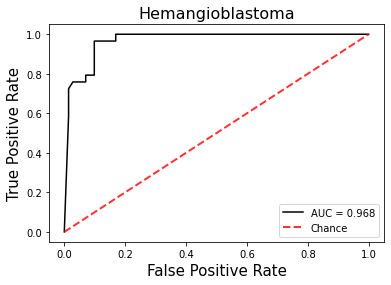

[0.72]


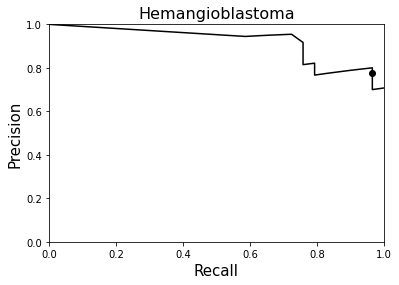

[[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1], [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1], [0.9166666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 0.9375, 0.0, 0.0, 0.9444444444444444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8378378378378378, 0.0, 0.1724137931034483, 0.0, 1.0, 0.75, 0.0, 1.0, 0.9166666666666666, 0.25, 0.0, 0.9791666666666666, 0.8666666666666667, 0.0, 0.03773584905660377, 1.0, 0.0, 0.8260869565217391, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.19047619047619047, 0.0, 0.041666666666666664, 0.08333333

/tmp/ipykernel_16017/3277614575.py:61: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


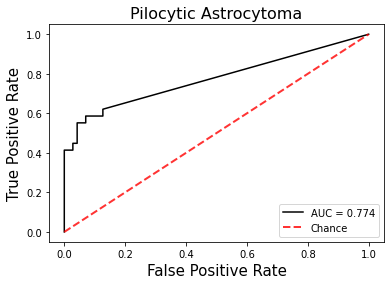

[0.07]


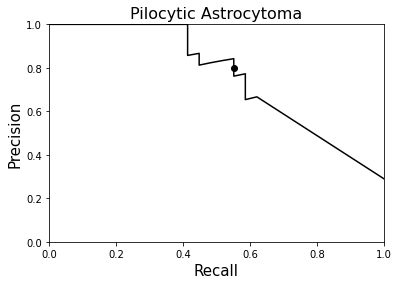

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.027777777777777776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.7741935483870968, 0.0, 0.0, 0.02702702702702703, 0.5806451612903226, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4444444444444444, 0.0, 0.0, 0.17777777777777778, 0.03773584905660377, 0.0, 0.0, 0.1956521739130435, 0.0, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.78378378378378

/tmp/ipykernel_16017/3277614575.py:61: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


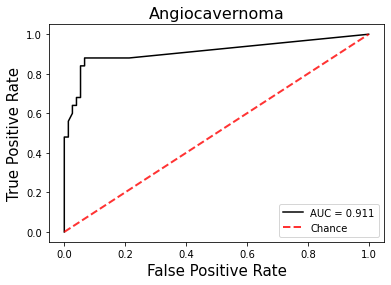

[0.27]


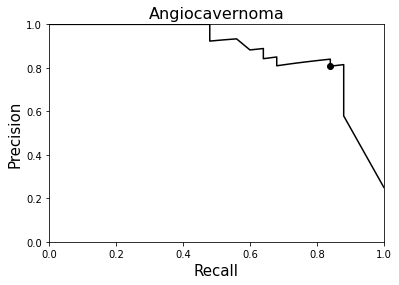

[[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0], [0.0, 0.0, 1.0, 0.0, 0.46875, 0.5625, 0.125, 1.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.7916666666666666, 0.0, 0.0, 0.0, 0.0, 0.19047619047619047, 0.2619047619047619, 0.9090909090909091, 0.0, 0.25, 0.0, 0.0, 0.0, 0.075, 0.0, 0.0, 0.0, 0.7096774193548387, 

/tmp/ipykernel_16017/3277614575.py:61: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


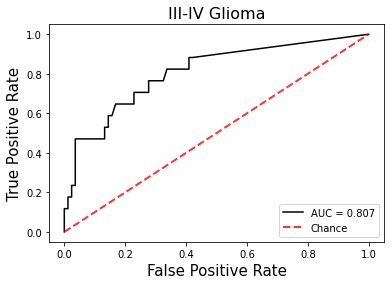

[0.52]


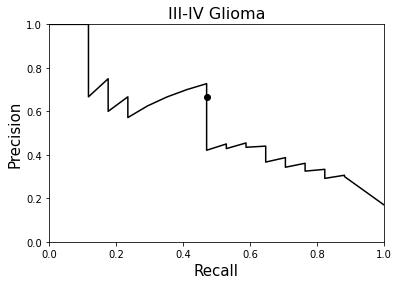

[[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.0, 0.8333333333333334, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.7307692307692307, 0.375, 0.3225806451612903, 0.0, 1.0, 0.0, 0.2903225806451613, 0.6896551724137931, 0.5, 0.0, 0.0, 0.0625, 0.0, 0.2916666666666667, 0.0, 0.7638888888888888, 0.08333333333333333, 0.0, 0.6444444444444445, 0.7358490566037735, 0.0, 0.4722222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018867924528301886,

In [42]:
reses = []
probs = []
index_temp = [1, 3, 0, 2]
names = ['Hemangioblastoma','Pilocytic Astrocytoma', 'Angiocavernoma', 'III-IV Glioma']
for idx, i in enumerate(index_temp):
    print('res==>:{}'.format(i))
    temp_y = np.zeros_like(val_labels)
    temp_y[val_labels==i] = 1
    print(indexs.shape)
    res, temp_res = collect_res_max_acc(indexs, test_pred_tumors[idx,:], temp_y)
    vis_roc([temp_res[0]], [temp_res[2]], names[idx])
    vis_pr([temp_res[0]], [temp_res[2]], [temp_res[-1]], names[idx])
    print(temp_res)
#     acc, p, r, f1score, roc_auc = cal_cls_res(temp_y,  test_pred_tumors[idx,:], np.array(test_pred_prob_tumors)[idx,:])


In [43]:
reses = []
probs = []
index_temp = [1, 3, 0, 2]
names = ['Hemangioblastoma','Pilocytic Astrocytoma', 'Angiocavernoma', 'III-IV Glioma']



for idx, i in enumerate(index_temp):
    print('res==>:{}'.format(i))
    temp_y = np.zeros_like(val_labels)
    temp_y[val_labels==i] = 1
    print(indexs.shape)
    res, temp_res = collect_res_max_acc(indexs, test_pred_tumors[idx,:], temp_y)
    print(temp_res[0], temp_res[1])
    

res==>:1
(3062,)
acc: 0.88
precision_score: 0.717948717948718
recall_score: 0.9655172413793104
f1_score: 0.8235294117647058
roc_auc: 0.9679456046624575
0.72
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1] [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
res==>:3
(3062,)
acc: 0.8
precision_score: 1.0
recall_score: 0.3103448275862069
f1_score: 0.4736842105263158
roc_auc: 0.7741622146673142
0.07
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,

In [47]:

reses = []
index_temp = [1, 3, 0, 2]
names = ['Hemangioblastoma','Pilocytic Astrocytoma', 'Angiocavernoma', 'III-IV Glioma']
for idx, i in enumerate(index_temp):
    print('res==>:{}'.format(i))
    temp_y = np.zeros_like(val_labels)
    temp_y[val_labels==i] = 1
    print(indexs.shape)
    
    # res,[label, opt_pred, mean_prob, max_bound]
    res, temp_res = collect_res_max_acc(indexs, test_pred_tumors[idx,:], temp_y)
    reses.append(temp_res)
    print(temp_res[0], temp_res[1])
    
datasets = []
tumor_type =[]
name = []
data_dir = '../data/version_expert/test.txt'
with open(data_dir, 'r') as f:
    strs = f.readlines()
    for j in strs:
        a = j.split('/')
        datasets.append(a[5])
        tumor_type.append(a[6])
        name.append(a[7])
#             print(a)
print(len(tumor_type))
# reses += [datasets, tumor_type, name]

res==>:1
(3062,)
acc: 0.88
precision_score: 0.717948717948718
recall_score: 0.9655172413793104
f1_score: 0.8235294117647058
roc_auc: 0.9679456046624575
0.72
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1] [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
res==>:3
(3062,)
acc: 0.8
precision_score: 1.0
recall_score: 0.3103448275862069
f1_score: 0.4736842105263158
roc_auc: 0.7741622146673142
0.07
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,

In [48]:
data2excel = {
    'datasets':datasets, 'tumor_type':tumor_type, 'name':name,
    'glabel':reses[3][0],'gp_temp':reses[3][1], "gpred_temp":reses[3][2], "gmax_temp":reses[3][3],
     'alabel':reses[2][0],'ap_temp':reses[2][1], "apred_temp":reses[2][2], "amax_temp":reses[2][3],
     'plabel':reses[1][0],'pp_temp':reses[1][1], "ppred_temp":reses[1][2], "pmax_temp":reses[1][3],
     'hlabel':reses[0][0],'hp_temp':reses[0][1], "hpred_temp":reses[0][2], "hmax_temp":reses[0][3],
}
df_tosave = pd.DataFrame(data2excel)
df_tosave.to_excel('../data/expert_res/prior_deskull_res_maxacc.xlsx', sheet_name='sheet1')
df_tosave

,datasets,tumor_type,name,glabel,gp_temp,gpred_temp,gmax_temp,alabel,ap_temp,apred_temp,amax_temp,plabel,pp_temp,ppred_temp,pmax_temp,hlabel,hp_temp,hpred_temp,hmax_temp
0,tumor_dataset2,hemangioblastoma,bai_lei,0,0,0.000000,0.52,0,0,0.000000,0.27,0,0,0.027778,0.07,1,1,0.916667,0.72
1,tumor_dataset2,III-IV_glioma,bai_zhi_yang,1,1,0.833333,0.52,0,0,0.000000,0.27,0,0,0.000000,0.07,0,0,0.000000,0.72
2,tumor_dataset1,angiocavernoma,cai_chun_jun,0,0,0.208333,0.52,1,1,1.000000,0.27,0,0,0.000000,0.07,0,0,0.000000,0.72
3,tumor_dataset2,hemangioblastoma,cai_er_hai,0,0,0.000000,0.52,0,0,0.000000,0.27,0,0,0.000000,0.07,1,1,1.000000,0.72
4,tumor_dataset1,III-IV_glioma,cao_yi_wen,1,0,0.000000,0.52,0,0,0.468750,0.27,0,0,0.000000,0.07,0,0,0.000000,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,tumor_dataset1,angiocavernoma,zhou_chao,0,0,0.000000,0.52,1,1,0.515152,0.27,0,0,0.000000,0.07,0,0,0.000000,0.72
96,tumor_dataset2,hemangioblastoma,zhou_he_hua,0,0,0.000000,0.52,0,0,0.000000,0.27,0,0,0.000000,0.07,1,1,0.724138,0.72
97,tumor_dataset1,angiocavernoma,zhou_he_ming,0,0,0.240000,0.52,1,1,0.560000,0.27,0,0,0.000000,0.07,0,0,0.000000,0.72
98,tumor_dataset2,hemangioblastoma,zhu_ya_fang,0,0,0.000000,0.52,0,0,0.000000,0.27,0,0,0.000000,0.07,1,1,1.000000,0.72
